# Project: Identify Customer Segments

In this project, unsupervised learning techniques will be applied to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The dataset are comming from Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (but are not included in the repo for the data terms and conditions):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. This information will be used to cluster the general population into groups with similar demographic properties. To see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

Starting step is loading in the demographics data for the general population into a pandas DataFrame, and doing the same for the feature attributes summary.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [3]:
# Checking the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.describe())
print(feat_info.describe())


            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min    

In [4]:
print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. This file will be used to help in making cleaning decisions.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. A little bit of parsing is needed to make use of it to identify and clean the data. Then data that matches a 'missing' or 'unknown' value code will be converted into a numpy NaN value.

In [5]:
# Identify missing or unknown data values
for column in azdias.columns:
    missing_values = feat_info.loc[feat_info["attribute"] == column,"missing_or_unknown"].values[0].split(",")
    first = 0
    last = len(missing_values) - 1
    
    for index, value in enumerate(missing_values):

        if index == first:
            value = value.split("[")[1]

        if index == last:
            value = value.split("]")[0]
        
        if value != '':
            try:
                value = float(value)
            except:
                print("Column :",column, "Missing Values: ", missing_values)
                print("value",value,"len",len(value))
                print(value, "Not a numerical value")

Column : CAMEO_DEUG_2015 Missing Values:  ['[-1', 'X]']
value X len 1
X Not a numerical value
Column : CAMEO_DEU_2015 Missing Values:  ['[XX]']
value XX len 2
XX Not a numerical value
Column : CAMEO_INTL_2015 Missing Values:  ['[-1', 'XX]']
value XX len 2
XX Not a numerical value


### Exploring the columns that has 'X' as unknown or missing values

In [6]:
X_values_list = ["CAMEO_DEUG_2015","CAMEO_DEU_2015","CAMEO_INTL_2015"]
for value in X_values_list:
    print(value+": ",azdias.loc[:,value].unique())

CAMEO_DEUG_2015:  [nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']
CAMEO_DEU_2015:  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
CAMEO_INTL_2015:  [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']


### Exploring the columns that has empty unknown or missing values

In [7]:
Empty_values_list = ["GFK_URLAUBERTYP","GREEN_AVANTGARDE","ANZ_PERSONEN","ANZ_TITEL","ANZ_HH_TITEL","KONSUMNAEHE","GEBAEUDETYP_RASTER","MOBI_REGIO","ONLINE_AFFINITAET","KBA13_ANZAHL_PKW"]
for value in Empty_values_list:
    print(value+": ",azdias.loc[:,value].unique())

GFK_URLAUBERTYP:  [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE:  [0 1]
ANZ_PERSONEN:  [ nan   2.   1.   0.   4.   3.   5.   7.   6.   8.  12.   9.  21.  10.  13.
  11.  14.  45.  20.  31.  29.  37.  16.  22.  15.  23.  18.  35.  17.  40.
  38.]
ANZ_TITEL:  [ nan   0.   1.   2.   4.   3.   6.]
ANZ_HH_TITEL:  [ nan   0.   1.   5.   2.   3.   7.   4.   6.   9.  15.  14.   8.  11.  10.
  12.  13.  20.  16.  17.  23.  18.]
KONSUMNAEHE:  [ nan   1.   5.   4.   3.   2.   6.   7.]
GEBAEUDETYP_RASTER:  [ nan   3.   4.   5.   1.   2.]
MOBI_REGIO:  [ nan   1.   3.   4.   5.   2.   6.]
ONLINE_AFFINITAET:  [  1.   3.   2.   5.   4.   0.  nan]
KBA13_ANZAHL_PKW:  [  nan  963.  712. ...,    2.   30.    7.]


### Exploring all columns

In [8]:
for value in azdias.columns:
    print(value+": ",azdias.loc[:,value].unique())

AGER_TYP:  [-1  2  3  0  1]
ALTERSKATEGORIE_GROB:  [2 1 3 4 9]
ANREDE_KZ:  [1 2]
CJT_GESAMTTYP:  [  2.   5.   3.   4.   1.   6.  nan]
FINANZ_MINIMALIST:  [3 1 4 2 5]
FINANZ_SPARER:  [4 5 2 3 1]
FINANZ_VORSORGER:  [3 2 1 5 4]
FINANZ_ANLEGER:  [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER:  [5 4 3 1 2]
FINANZ_HAUSBAUER:  [3 5 2 4 1]
FINANZTYP:  [4 1 6 5 2 3]
GEBURTSJAHR:  [   0 1996 1979 1957 1963 1943 1964 1974 1975 1941 1993 1946 1988 1991 1966
 1949 1982 1972 1990 1985 1989 1948 1935 1997 1994 1987 2002 1950 1965 1969
 1978 1958 1944 1967 1977 1960 1970 1973 1971 1937 1947 1926 1954 1981 1962
 1992 2008 1976 1928 1927 1968 1940 1952 1961 2006 1938 1945 1942 1984 1930
 1980 1959 1986 1931 1955 1983 2010 1951 1921 1929 1939 2001 1995 1956 1953
 2012 1934 1913 1914 1922 2004 1936 2009 1915 2003 2013 1998 2007 1932 2005
 1923 1925 2015 1933 2017 2000 1999 2014 1920 1918 1924 2016 2011 1908 1919
 1916 1917 1912 1911 1909 1910 1904 1906 1905 1900 1907 1902]
GFK_URLAUBERTYP:  [ 10.   1.   5.  12.   9.  

### Identifying missing or unknown data values and convert them to NaNs

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
for column in azdias.columns:
    missing_values = feat_info.loc[feat_info["attribute"] == column,"missing_or_unknown"].values[0].split(",")
    
    first = 0
    last = len(missing_values) - 1
    
    for index, value in enumerate(missing_values):

        if index == first:
            value = value.split("[")[1]

        if index == last:
            value = value.split("]")[0]
        
        if value != '':
            try:
                value = float(value)
            except:
                pass
            
            azdias[column] = azdias[column].map(lambda x: np.nan if x == value else x)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column?

(array([ 0.04599383,  0.04717315,  0.        ,  0.00117933,  0.00117933,
         0.00117933,  0.00117933,  0.00117933,  0.        ,  0.00117933]),
 array([  0.        ,   9.97576359,  19.95152717,  29.92729076,
         39.90305435,  49.87881794,  59.85458152,  69.83034511,
         79.8061087 ,  89.78187229,  99.75763587]),
 <a list of 10 Patch objects>)

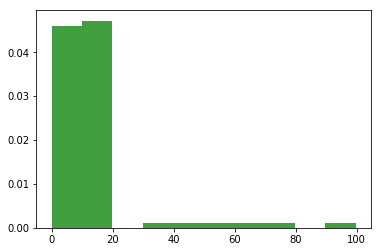

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missings_percentage = (azdias.isnull().sum(axis=0)/len(azdias)) * 100

plt.hist(missings_percentage, 10, density=True, facecolor='g', alpha=0.75)


In [11]:
# Investigate patterns in the amount of missing data in each column.
print("###################### columns that have missing values more than or equal 75% #########################")
for index, column in enumerate(azdias.columns):
    if missings_percentage[index] >= 75:
        print("column :",column) 
        print("missing precentage = ",str(missings_percentage[index])+"%")
        print("unique values" ,azdias[column].unique())
        print(feat_info.loc[feat_info["attribute"] == column,:])

print("###################### columns that have missing values between (exclusive) 9-75% #########################")
for index, column in enumerate(azdias.columns):
    if missings_percentage[index] > 10 and missings_percentage[index] < 75:
        print("column :",column) 
        print("missing precentage = ",str(missings_percentage[index])+"%")
        print("unique values" ,azdias[column].unique())
        print(feat_info.loc[feat_info["attribute"] == column,:])

print("###################### columns that have missing values less than 10% #########################")
for index, column in enumerate(azdias.columns):
    if missings_percentage[index] < 10:
        print("column :",column) 
        print("missing precentage = ",str(missings_percentage[index])+"%")
        print("unique values" ,azdias[column].unique())
        print(feat_info.loc[feat_info["attribute"] == column,:])

###################### columns that have missing values more than or equal 75% #########################
column : AGER_TYP
missing precentage =  76.9554352961%
unique values [ nan   2.   3.   1.]
  attribute information_level         type missing_or_unknown
0  AGER_TYP            person  categorical             [-1,0]
column : TITEL_KZ
missing precentage =  99.7576358726%
unique values [ nan   4.   1.   3.   5.   2.]
   attribute information_level         type missing_or_unknown
40  TITEL_KZ            person  categorical             [-1,0]
###################### columns that have missing values between (exclusive) 9-75% #########################
column : GEBURTSJAHR
missing precentage =  44.0202822869%
unique values [   nan  1996.  1979.  1957.  1963.  1943.  1964.  1974.  1975.  1941.
  1993.  1946.  1988.  1991.  1966.  1949.  1982.  1972.  1990.  1985.
  1989.  1948.  1935.  1997.  1994.  1987.  2002.  1950.  1965.  1969.
  1978.  1958.  1944.  1967.  1977.  1960.  1970.  1973.  19

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print("number of columns before removing missing columns = ", len(azdias.columns))
# Keeping the columns with missing less than 30%
azdias_without_missing_columns = azdias.loc[:,azdias.columns[np.where(np.array(missings_percentage)< 13)[0]]]
print("number of columns after removing missing columns = ", len(azdias_without_missing_columns.columns))
print(azdias_without_missing_columns.columns)

number of columns before removing missing columns =  85
number of columns after removing missing columns =  63
Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMN

#### Step 1.1.3: Assess Missing Data in Each Row

A similar assessment for the rows of the dataset will be performed. How much data is missing in each row? 

(891221,)


(array([  1.56170539e-01,   1.01454481e-02,   3.52933580e-03,
          1.04706199e-03,   6.27637406e-05,   3.82858817e-03,
          2.47627591e-04,   1.12032206e-04,   6.00175592e-03,
          9.76393877e-03]),
 array([  0.        ,   5.23809524,  10.47619048,  15.71428571,
         20.95238095,  26.19047619,  31.42857143,  36.66666667,
         41.9047619 ,  47.14285714,  52.38095238]),
 <a list of 10 Patch objects>)

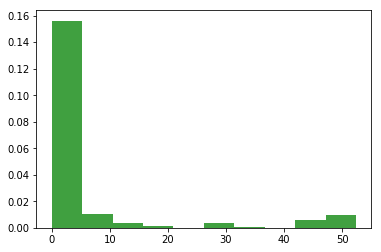

In [13]:
# How much data is missing in each row of the dataset?
row_missings_percentage = (azdias_without_missing_columns.isnull().values.sum(axis=1)/len(azdias_without_missing_columns.columns)) * 100
print(row_missings_percentage.shape)
plt.hist(row_missings_percentage, 10, density=True, facecolor='g', alpha=0.75)


In [14]:
# Divide the data into two subsets based on the number of missing
# values in each row.

low_row_missings = azdias_without_missing_columns.loc[row_missings_percentage < 5,:]
high_row_missings = azdias_without_missing_columns.loc[row_missings_percentage >= 5,:] #(azdias_without_missing_columns.isnull().values.sum(axis=1)/len(azdias_without_missing_columns.columns)) * 100

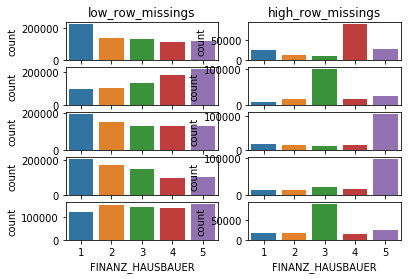

In [15]:
# Compare the distribution of values for five columns where there are
# no or few missing values, between the two subsets.

columns = ["FINANZ_SPARER","FINANZ_VORSORGER","FINANZ_ANLEGER","FINANZ_UNAUFFAELLIGER","FINANZ_HAUSBAUER"]
fig, axs = plt.subplots(5, 2)#,subplot_kw = dict(polar = True))
for i in range(5):
    sns.countplot(low_row_missings[columns[i]],ax=axs[i,0])
    sns.countplot(high_row_missings[columns[i]],ax=axs[i,1])
    if i == 0:
        axs[i,0].set_title('low_row_missings')
        axs[i,1].set_title('high_row_missings')
plt.show()

### Step 1.2: Select and Re-Encode Features
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, ordinarily encode the levels as dummy variables is needed. Depending on the number of categories, one of the following is performed:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [16]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
multi_level_can_be_encoded = []
categorical_or_mixed_columns = feat_info.loc[(feat_info[feat_info.columns[2]]=="categorical"),"attribute"].values
for col in categorical_or_mixed_columns:
    if col in low_row_missings.columns:
        unique_values = low_row_missings[col].unique()
        if len(unique_values) == 2: 
            print("col = ", col,"is binary")
            print("its values = ",unique_values)
            for val in unique_values:
                try:
                    float(val)
                except:
                    print("needs to be re-encoded")
                    break
print("#############################################################")
for col in categorical_or_mixed_columns:
    if col in low_row_missings.columns:
        unique_values = low_row_missings[col].unique()
        if len(unique_values) > 2:
            print("col = ", col,"is multi-level, can be re-encoded")
            print("its values = ",unique_values)
            multi_level_can_be_encoded.append(col)

col =  ANREDE_KZ is binary
its values =  [2 1]
col =  GREEN_AVANTGARDE is binary
its values =  [0 1]
col =  SOHO_KZ is binary
its values =  [ 1.  0.]
col =  VERS_TYP is binary
its values =  [ 2.  1.]
col =  OST_WEST_KZ is binary
its values =  ['W' 'O']
needs to be re-encoded
#############################################################
col =  CJT_GESAMTTYP is multi-level, can be re-encoded
its values =  [ 5.  3.  2.  4.  1.  6.]
col =  FINANZTYP is multi-level, can be re-encoded
its values =  [1 5 2 4 6 3]
col =  GFK_URLAUBERTYP is multi-level, can be re-encoded
its values =  [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   6.   2.]
col =  LP_FAMILIE_FEIN is multi-level, can be re-encoded
its values =  [  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]
col =  LP_FAMILIE_GROB is multi-level, can be re-encoded
its values =  [ 3.  1.  5.  2.  4.]
col =  LP_STATUS_FEIN is multi-level, can be re-encoded
its values =  [  2.   3.   4.   1.  10.   9.   5.   8.   6.   7.]
col =  LP_ST

In [17]:
# Re-encode categorical variable(s) to be kept in the analysis.
low_row_missings_binary_reencoded = low_row_missings.copy()
for i,val in enumerate(low_row_missings["OST_WEST_KZ"].unique()):
    low_row_missings_binary_reencoded.loc[low_row_missings["OST_WEST_KZ"]==val,"OST_WEST_KZ"] = i
    

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

In [18]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
PRAEGENDE_JUGENDJAHRE_val_decade_Movement_dic = {
1: ["40s","Mainstream"],
2: ["40s","Avantgarde"],
3: ["50s","Mainstream"],
4: ["50s","Avantgarde"],
5: ["60s","Mainstream"],
6: ["60s","Avantgarde"],
7: ["60s","Avantgarde"],
8: ["70s","Mainstream"],
9: ["70s","Avantgarde"],
10: ["80s","Mainstream"],
11: ["80s","Avantgarde"],
12: ["80s","Mainstream"],
13: ["80s","Avantgarde"],
14: ["90s","Mainstream"],
15: ["90s","Avantgarde"]
}

PRAEGENDE_JUGENDJAHRE_decade_interval_dic = {
"40s":0,
"50s":1,
"60s":2,
"70s":3,
"80s":4,
"90s":5
}

PRAEGENDE_JUGENDJAHRE_movement_binary_dic = {
    "Mainstream":0,
    "Avantgarde":1
}

low_row_missings_binary_reencoded_PRAEGENDE_fixed = low_row_missings_binary_reencoded.copy()
low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_decade"] = 0
low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_movement"] = 0

low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_decade"] = \
low_row_missings_binary_reencoded.loc[~low_row_missings_binary_reencoded["PRAEGENDE_JUGENDJAHRE"].isnull() \
,"PRAEGENDE_JUGENDJAHRE"].apply(lambda x: PRAEGENDE_JUGENDJAHRE_decade_interval_dic[ \
PRAEGENDE_JUGENDJAHRE_val_decade_Movement_dic[x][0]])

low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_movement"] = \
low_row_missings_binary_reencoded.loc[~low_row_missings_binary_reencoded["PRAEGENDE_JUGENDJAHRE"].isnull() \
,"PRAEGENDE_JUGENDJAHRE"].apply(lambda x: PRAEGENDE_JUGENDJAHRE_movement_binary_dic[ \
PRAEGENDE_JUGENDJAHRE_val_decade_Movement_dic[x][1]])
                         
    
print(low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_movement"].unique())
print(low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_decade"].unique())

[  0.   1.  nan]
[  5.   3.   1.   4.   2.  nan   0.]


In [19]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

print(low_row_missings_binary_reencoded_PRAEGENDE_fixed["CAMEO_INTL_2015"].unique())

low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed = low_row_missings_binary_reencoded_PRAEGENDE_fixed.copy()
low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_wealth"] = 0
low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_life"] = 0

low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_wealth"] = \
low_row_missings_binary_reencoded_PRAEGENDE_fixed.loc[~low_row_missings_binary_reencoded_PRAEGENDE_fixed["CAMEO_INTL_2015"].isnull() \
,"CAMEO_INTL_2015"].apply(lambda x: int(int(x)/10))
#if x not np.isnan(x))


low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_life"] = \
low_row_missings_binary_reencoded_PRAEGENDE_fixed.loc[~low_row_missings_binary_reencoded_PRAEGENDE_fixed["CAMEO_INTL_2015"].isnull() \
,"CAMEO_INTL_2015"].apply(lambda x: int(int(x)%10))
                         
    
print(low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_wealth"].unique())
print(low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_life"].unique())



['51' '24' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '12' '25' nan
 '23' '31' '52' '35' '45' '44' '32']
[  5.   2.   4.   1.   3.  nan]
[  1.   4.   3.   2.   5.  nan]


#### Step 1.2.3: Complete Feature Selection

The dataframe now should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [20]:
mixed = feat_info.loc[(feat_info[feat_info.columns[2]]=="mixed"),"attribute"].values
mixed_filtered = [m for m in mixed if m in low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed.columns]

low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed.drop(multi_level_can_be_encoded, axis=1, inplace=True)
low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed.drop(mixed_filtered, axis=1, inplace=True)

In [22]:
# Saving the preprocessed data at this step
import pickle
with open('preprocessing.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed, file)

### Step 1.3: Create a Cleaning Function

Cleaning up the general population demographics data is finished, but the same cleaning steps on the customer demographics data is need as well. Therefore all the needed steps are summarized in the following function to execute the main feature selection, encoding, and re-engineering steps you performed above.

In [23]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # convert missing value codes into NaNs, ...
    for column in azdias.columns:
        missing_values = feat_info.loc[feat_info["attribute"] == column,"missing_or_unknown"].values[0].split(",")

        first = 0
        last = len(missing_values) - 1

        for index, value in enumerate(missing_values):

            if index == first:
                value = value.split("[")[1]

            if index == last:
                value = value.split("]")[0]

            if value != '':
                try:
                    value = float(value)
                except:
                    pass

                azdias[column] = azdias[column].map(lambda x: np.nan if x == value else x)
    
    # remove selected columns and rows, ...
    missings_column_percentage = (azdias.isnull().sum(axis=0)/len(azdias)) * 100
    azdias_without_missing_columns = azdias.loc[:,azdias.columns[np.where(np.array(missings_percentage)< 13)[0]]]
    
    row_missings_percentage = (azdias_without_missing_columns.isnull().values.sum(axis=1)/len(azdias_without_missing_columns.columns)) * 100
    low_row_missings = azdias_without_missing_columns.loc[row_missings_percentage < 5,:]
    
    low_row_missings_binary_reencoded = low_row_missings.copy()
    for i,val in enumerate(low_row_missings["OST_WEST_KZ"].unique()):
        low_row_missings_binary_reencoded.loc[low_row_missings["OST_WEST_KZ"]==val,"OST_WEST_KZ"] = i
        
    PRAEGENDE_JUGENDJAHRE_val_decade_Movement_dic = {
    1: ["40s","Mainstream"],
    2: ["40s","Avantgarde"],
    3: ["50s","Mainstream"],
    4: ["50s","Avantgarde"],
    5: ["60s","Mainstream"],
    6: ["60s","Avantgarde"],
    7: ["60s","Avantgarde"],
    8: ["70s","Mainstream"],
    9: ["70s","Avantgarde"],
    10: ["80s","Mainstream"],
    11: ["80s","Avantgarde"],
    12: ["80s","Mainstream"],
    13: ["80s","Avantgarde"],
    14: ["90s","Mainstream"],
    15: ["90s","Avantgarde"]
    }

    PRAEGENDE_JUGENDJAHRE_decade_interval_dic = {
    "40s":0,
    "50s":1,
    "60s":2,
    "70s":3,
    "80s":4,
    "90s":5
    }

    PRAEGENDE_JUGENDJAHRE_movement_binary_dic = {
        "Mainstream":0,
        "Avantgarde":1
    }
    
    ###
    low_row_missings_binary_reencoded_PRAEGENDE_fixed = low_row_missings_binary_reencoded.copy()
    low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_decade"] = 0
    low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_movement"] = 0

    low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_decade"] = \
    low_row_missings_binary_reencoded.loc[~low_row_missings_binary_reencoded["PRAEGENDE_JUGENDJAHRE"].isnull() \
    ,"PRAEGENDE_JUGENDJAHRE"].apply(lambda x: PRAEGENDE_JUGENDJAHRE_decade_interval_dic[ \
    PRAEGENDE_JUGENDJAHRE_val_decade_Movement_dic[x][0]])
    #if x not np.isnan(x))

    low_row_missings_binary_reencoded_PRAEGENDE_fixed["PRAEGENDE_JUGENDJAHRE_movement"] = \
    low_row_missings_binary_reencoded.loc[~low_row_missings_binary_reencoded["PRAEGENDE_JUGENDJAHRE"].isnull() \
    ,"PRAEGENDE_JUGENDJAHRE"].apply(lambda x: PRAEGENDE_JUGENDJAHRE_movement_binary_dic[ \
    PRAEGENDE_JUGENDJAHRE_val_decade_Movement_dic[x][1]])
    
    ### 
    low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed = low_row_missings_binary_reencoded_PRAEGENDE_fixed.copy()
    low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_wealth"] = 0
    low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_life"] = 0

    low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_wealth"] = \
    low_row_missings_binary_reencoded_PRAEGENDE_fixed.loc[~low_row_missings_binary_reencoded_PRAEGENDE_fixed["CAMEO_INTL_2015"].isnull() \
    ,"CAMEO_INTL_2015"].apply(lambda x: int(int(x)/10))
    #if x not np.isnan(x))


    low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed["CAMEO_INTL_2015_life"] = \
    low_row_missings_binary_reencoded_PRAEGENDE_fixed.loc[~low_row_missings_binary_reencoded_PRAEGENDE_fixed["CAMEO_INTL_2015"].isnull() \
    ,"CAMEO_INTL_2015"].apply(lambda x: int(int(x)%10))
    
    
    # select, re-encode, and engineer column values.
    multi_level_can_be_encoded = []
    categorical_or_mixed_columns = feat_info.loc[(feat_info[feat_info.columns[2]]=="categorical"),"attribute"].values

    for col in categorical_or_mixed_columns:
        if col in low_row_missings.columns:
            unique_values = low_row_missings[col].unique()
            if len(unique_values) > 2:
                multi_level_can_be_encoded.append(col)
    
    mixed = feat_info.loc[(feat_info[feat_info.columns[2]]=="mixed"),"attribute"].values
    mixed_filtered = [m for m in mixed if m in low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed.columns]
    
    low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed.drop(multi_level_can_be_encoded, axis=1, inplace=True)
    low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed.drop(mixed_filtered, axis=1, inplace=True)
    
    return low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed
    # Return the cleaned dataframe.
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before dimensionality reduction techniques is applied to the data, feature scaling is needed so that the principal component vectors are not influenced by the natural differences in scale for features.

sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to the data, the remaining missing values have to be imputed.

In [24]:
# Clean the dataset of all NaN values, by imputing them.
imp = Imputer()
low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed_imputed = imp.fit_transform(low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed)

In [25]:
# Apply feature scaling to the general population demographics data.
scaling = StandardScaler()
low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed_imputed_scaled = scaling.fit_transform(low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed_imputed)

### Step 2.2: Perform Dimensionality Reduction


- Using sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 
- At the beginning no parameters are set (so all components are computed).
- Then the ratio of variance explained will be checked out by each principal component as well as the cumulative variance explained.  To be able to choose the number of components that summarize most of the data, and can be used for efficient dimensionality reduction. 
- Then PCA instance will be re-fit using this number of compnents.

In [26]:
# Apply PCA to the data.
pca = PCA()
PCA_data = pca.fit_transform(low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed_imputed_scaled)


Text(0.5,1,'Explained Variance Per Principal Component')

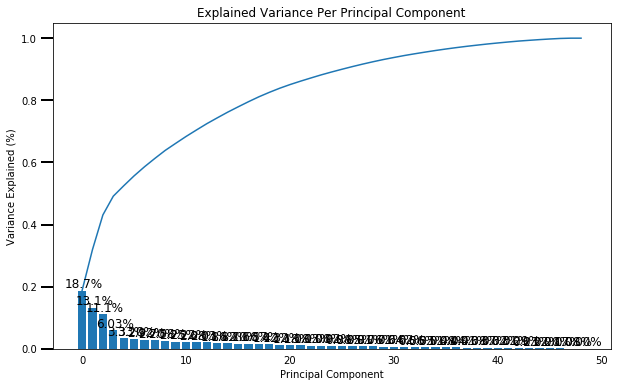

In [27]:
# Investigate the variance accounted for by each principal component.

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')

In [28]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(30)
PCA_data = pca.fit_transform(low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed_imputed_scaled)

with open('pca.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(pca, file)


In [29]:
print(type(pca.components_))
print(low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed_imputed_scaled.shape)

<class 'numpy.ndarray'>
(729051, 49)


### Step 2.3: Interpret Principal Components

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In the following snippets the weight of each variable on the first few components will be visualized.

In [58]:
# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = low_row_missings_binary_reencoded_PRAEGENDE_CAMEO_fixed.keys())
components.index = dimensions


# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

def interpret_principal(principal):
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))
    
    # Plot the feature weights as a function of the components
    component_x = components.sort_values(by=["Dimension "+str(principal+1)], ascending=False, axis = 1).loc["Dimension "+str(principal+1),:]
    print(component_x)
    component_x.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions[principal-1], rotation=0)

    # Display the explained variance ratios
    ax.text(0-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(pca.explained_variance_ratio_[principal]))

SEMIO_KAEM                        0.3219
ANREDE_KZ                         0.3148
SEMIO_DOM                         0.2818
SEMIO_KRIT                        0.2539
FINANZ_HAUSBAUER                  0.1912
HH_EINKOMMEN_SCORE                0.1775
SEMIO_ERL                         0.1626
SEMIO_RAT                         0.1611
CAMEO_INTL_2015_wealth            0.1505
ORTSGR_KLS9                       0.1495
EWDICHTE                          0.1473
ARBEIT                            0.1159
RELAT_AB                          0.1073
ANZ_HAUSHALTE_AKTIV               0.1017
FINANZ_ANLEGER                    0.0996
FINANZ_SPARER                     0.0820
PRAEGENDE_JUGENDJAHRE_decade      0.0523
SEMIO_PFLICHT                     0.0454
SEMIO_TRADV                       0.0444
OST_WEST_KZ                       0.0393
ANZ_HH_TITEL                      0.0298
FINANZ_UNAUFFAELLIGER             0.0290
VERS_TYP                          0.0251
HEALTH_TYP                        0.0187
SOHO_KZ         

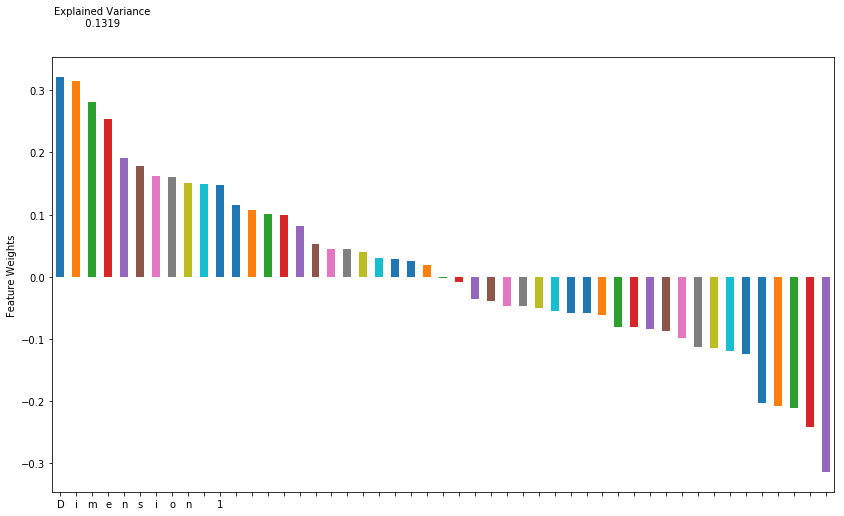

In [59]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_principal(1)

ORTSGR_KLS9                       0.2780
EWDICHTE                          0.2737
CAMEO_INTL_2015_wealth            0.2400
ARBEIT                            0.2152
HH_EINKOMMEN_SCORE                0.2028
RELAT_AB                          0.1998
FINANZ_HAUSBAUER                  0.1804
ANZ_HAUSHALTE_AKTIV               0.1743
SEMIO_SOZ                         0.1690
SEMIO_VERT                        0.1621
SEMIO_FAM                         0.1504
RETOURTYP_BK_S                    0.1439
SEMIO_KULT                        0.1227
FINANZ_VORSORGER                  0.0808
ALTERSKATEGORIE_GROB              0.0693
SEMIO_LUST                        0.0692
OST_WEST_KZ                       0.0685
ANZ_HH_TITEL                      0.0631
VERS_TYP                          0.0598
SEMIO_REL                         0.0278
SEMIO_MAT                         0.0255
ANZ_TITEL                         0.0069
WOHNDAUER_2008                   -0.0026
SOHO_KZ                          -0.0029
HEALTH_TYP      

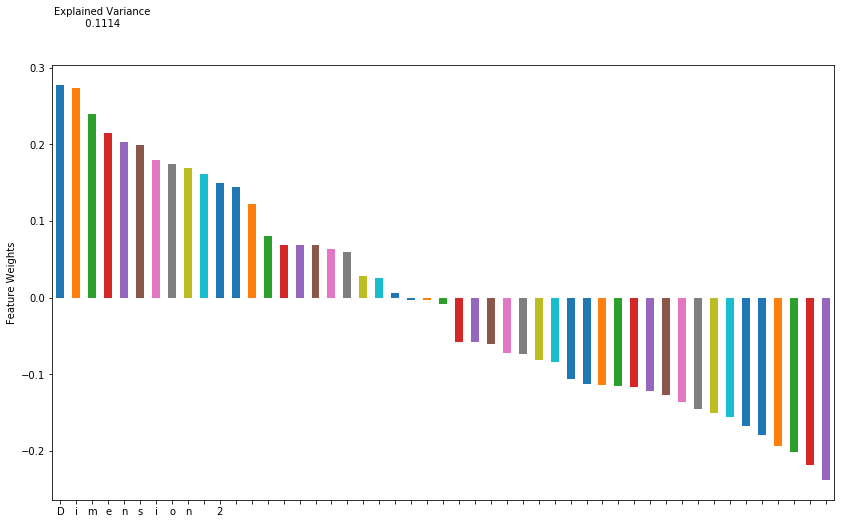

In [60]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_principal(2)

GREEN_AVANTGARDE                  0.4538
PRAEGENDE_JUGENDJAHRE_movement    0.4527
EWDICHTE                          0.2767
ORTSGR_KLS9                       0.2722
ONLINE_AFFINITAET                 0.1707
ANZ_PERSONEN                      0.1359
SEMIO_DOM                         0.1119
RELAT_AB                          0.1046
FINANZ_UNAUFFAELLIGER             0.0999
FINANZ_MINIMALIST                 0.0962
SEMIO_KAEM                        0.0913
CAMEO_INTL_2015_life              0.0790
ARBEIT                            0.0629
ANZ_TITEL                         0.0551
SEMIO_RAT                         0.0530
SEMIO_TRADV                       0.0510
PRAEGENDE_JUGENDJAHRE_decade      0.0461
ANREDE_KZ                         0.0371
SEMIO_PFLICHT                     0.0280
VERS_TYP                          0.0257
ANZ_HH_TITEL                      0.0236
WOHNDAUER_2008                    0.0221
SEMIO_KRIT                        0.0145
HEALTH_TYP                        0.0106
SOHO_KZ         

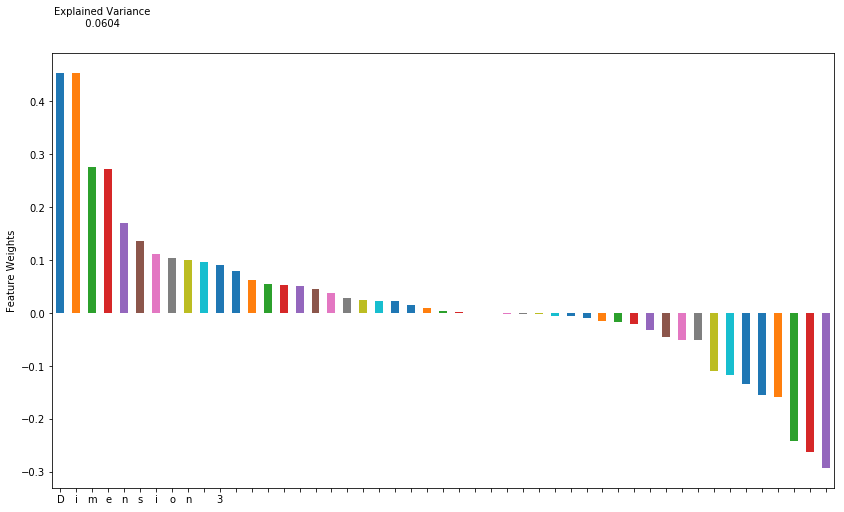

In [61]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_principal(3)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

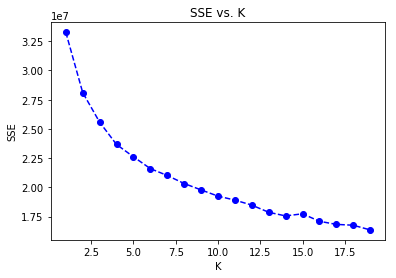

In [33]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,20))

for center in centers:
    scores.append(get_kmeans_score(PCA_data, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

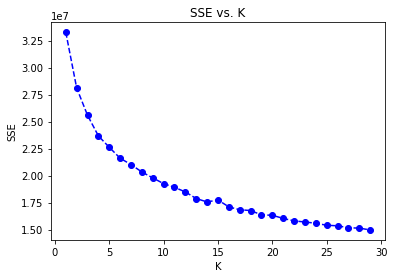

In [39]:
centers = list(range(1,30))

for center in range(20,30):
    scores.append(get_kmeans_score(PCA_data, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [40]:
with open('kmeans_scores.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(scores, file)

In [63]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_data = KMeans(n_clusters=8).fit(PCA_data)

### Step 3.2: Apply All Steps to the Customer Data

Now clusters and cluster centers for the general population are known, it's time to see how the customer data maps on to those clusters. 

Applying the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function.

In [37]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data(customers)
customers_cleaned = customers.copy()
customers_imputed = imp.transform(customers_cleaned)
customers_scaled = scaling.transform(customers_imputed)
customers_pca = pca.transform(customers_scaled)
customers_clusters = kmeans_data.predict(customers_pca)

In [ ]:
with open('customers_clusters.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(customers_clusters, file)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, demographics of the general population of Germany are clustered, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In the following snipet, the two cluster distributions will be compared to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

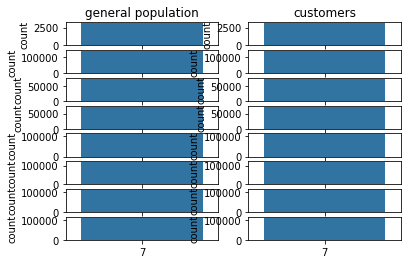

In [70]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, axs = plt.subplots(8, 2)
for i in range(8):
    sns.countplot(kmeans_data.labels_[np.where(np.array(kmeans_data.labels_)==i)[0]],ax=axs[i,0])
    sns.countplot(customers_clusters[np.where(np.array(customers_clusters)==i)[0]],ax=axs[i,1])
    if i == 0:
        axs[i,0].set_title('general population')
        axs[i,1].set_title('customers')
plt.show()